In [1]:
#%pip install tbats

In [2]:
from azureml.core import Workspace, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
from tbats import TBATS
import pickle
import warnings
warnings.filterwarnings('ignore')

# Lasten päivystyksen kolmivuorokohtaisen TBATS-mallin koulutus

In [3]:
start = pd.Timestamp('2017-01-01T00')
train_test_8h = pd.Timestamp('2019-01-01')
end = pd.Timestamp('2019-12-31')

In [ ]:
subscription_id = '4371739e-d07f-42d5-a3a6-efa120c1e246'
resource_group = 'husfd-tu-dip-potilasvirrat'
workspace_name = 'husfd-tu-dip-potilasvirrat-ml'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='uranus27_1')
df = dataset.to_pandas_dataframe()
df.dropna(subset=['alkuhetki', 'loppuhetki'], inplace=True)
df.drop_duplicates(subset='kaynti_numero', inplace=True)
df = df[df['varaustyyppi_selite'] != 'PÄIV PKL soitto']
df = df[(df['kayntityyppi_selite'] != 'Hoitokäynti') & (df['kayntityyppi_selite'] != 'Ohjattu muualle') & (df['kayntityyppi_selite'] !='HYKSin Oy:n potilas') 
    & (df['kayntityyppi_selite'] != 'Sarjahoitokäynti') & (df['kayntityyppi_selite'] != 'Ensikäynti')]
df = df[(df.alkuhetki >= start) & (df.alkuhetki < end)]
df_train = df[df['alkuhetki'] < train_test_8h]
df_test = df[df['alkuhetki'] >= train_test_8h]
df_train = df_train.sort_values(by='alkuhetki')

In [5]:
df_train['alkuhetki'] = pd.to_datetime(df_train['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df_train['loppuhetki'] = pd.to_datetime(df_train['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df_train = df_train[df_train['alkuhetki'] <= df_train['loppuhetki']]
df_train['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df_train['alkuhetki'], right = df_train['loppuhetki'], closed='neither')
df_train['palveluaika'] = ((df_train['loppuhetki'] - df_train['alkuhetki']).astype('timedelta64[s]') / 3600)
print('Keskiarvo:', df_train.palveluaika.mean())

Keskiarvo: 2.1664471990526204


In [6]:
df_test['alkuhetki'] = pd.to_datetime(df_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
df_test['loppuhetki'] = pd.to_datetime(df_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
df_test = df_test[df_test['alkuhetki'] <= df_test['loppuhetki']]
df_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = df_test['alkuhetki'], right = df_test['loppuhetki'], closed='neither')
df_test['palveluaika'] = ((df_test['loppuhetki'] - df_test['alkuhetki']).astype('timedelta64[s]') / 3600)

In [7]:
aika = start
span_8h = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 17536, 8)]})
timestamp_8h = [aika + timedelta(hours=x) for x in range(0, 17528, 8)] 
df_train_8h = pd.DataFrame(data={'time':timestamp_8h})
df_train_8h['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_8h['time'][0:-1], right = span_8h['time'][1:], closed='left')
df_train_8h['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_8h['timespan']).contains(b) for b in df_train['alkuhetki']]).sum()
df_train_8h['departments'] = pd.DataFrame([pd.arrays.IntervalArray(df_train_8h['timespan']).contains(b) for b in df_train['loppuhetki']]).sum()
df_train_8h.set_index('time', inplace=True)
df_train_8h.head()

,timespan,arrivals,departments
time,,,
2017-01-01 00:00:00,"[2017-01-01, 2017-01-01 08:00:00)",8,3
2017-01-01 08:00:00,"[2017-01-01 08:00:00, 2017-01-01 16:00:00)",38,27
2017-01-01 16:00:00,"[2017-01-01 16:00:00, 2017-01-02)",38,49
2017-01-02 00:00:00,"[2017-01-02, 2017-01-02 08:00:00)",8,11
2017-01-02 08:00:00,"[2017-01-02 08:00:00, 2017-01-02 16:00:00)",12,9


In [8]:
aika = start
span_8h = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 21152, 8)]})
timestamp_8h = [aika + timedelta(hours=x) for x in range(0, 21144, 8)]
df_8h = pd.DataFrame(data={'time':timestamp_8h})
df_8h['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_8h['time'][0:-1], right = span_8h['time'][1:], closed='left')
df_8h['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(df_8h['timespan']).contains(b) for b in df['alkuhetki']]).sum()
df_8h['departments'] = pd.DataFrame([pd.arrays.IntervalArray(df_8h['timespan']).contains(b) for b in df['loppuhetki']]).sum()

In [9]:
aika = train_test_8h
span_8h_test = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 3632, 8)]}) 
timestamp_8h_test = [aika + timedelta(hours=x) for x in range(0, 3624, 8)] 
df_test_8h = pd.DataFrame(data={'time':timestamp_8h_test})
df_test_8h['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_8h_test['time'][0:-1], right = span_8h_test['time'][1:], closed='left')
df_test_8h['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_8h['timespan']).contains(b) for b in df_test['alkuhetki']]).sum()
df_test_8h['departments'] = pd.DataFrame([pd.arrays.IntervalArray(df_test_8h['timespan']).contains(b) for b in df_test['loppuhetki']]).sum()
df_test_8h.set_index('time', inplace=True)

### TBATS

In [10]:
#tbats = TBATS(seasonal_periods=[3, 21, 1095])
#tbats = tbats.fit(df_train_8h.arrivals)
tbats = pickle.load(open('tbats_ER_2017-2019-triple_final.pkl', 'rb'))
print(tbats.summary())

#aika = train_test_8h
#span_8h_test = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 5142, 8)]}) # 121
#timestamp_8h_test = [aika + timedelta(hours=x) for x in range(0, 5136, 8)] # 120
#df_test_8h = pd.DataFrame(data={'time':timestamp_8h_test})
new_index = pd.date_range("2019-01-01", "2019-06-01", freq="8H") 
additive = pd.DataFrame(np.nan, index=new_index[:-1], columns=df_train_8h.columns)
additive.timespan = pd.arrays.IntervalArray.from_arrays(left = new_index[:-1], right = new_index[1:], closed='left')
additive['ennuste_TBATS'] = tbats.forecast(steps=453)

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [   3.   21. 1095.]
Seasonal harmonics [1 6 2]
ARMA errors (p, q): (3, 2)
Smoothing (Alpha): 0.080571
Seasonal Parameters (Gamma): [-5.38003978e-05  1.72090601e-06  9.51824571e-06  2.43966230e-05
  4.92068575e-06  6.04671091e-06]
AR coefficients [2.43966230e-05 4.92068575e-06 6.04671091e-06]
MA coefficients [-0.2209454   0.03906122]
Seed vector [ 19.99972435 -17.67153946  -7.13682153   4.51618581   2.19436119
   0.74016001  -0.38363177  -1.7370937   -2.92341593   0.18492809
  -0.67934056  -0.16124334   0.74182746   2.11869468   3.46857567
   2.18692446  -1.26885271   1.7943664   -0.53136468   0.
   0.           0.           0.           0.        ]

AIC 25355.222760


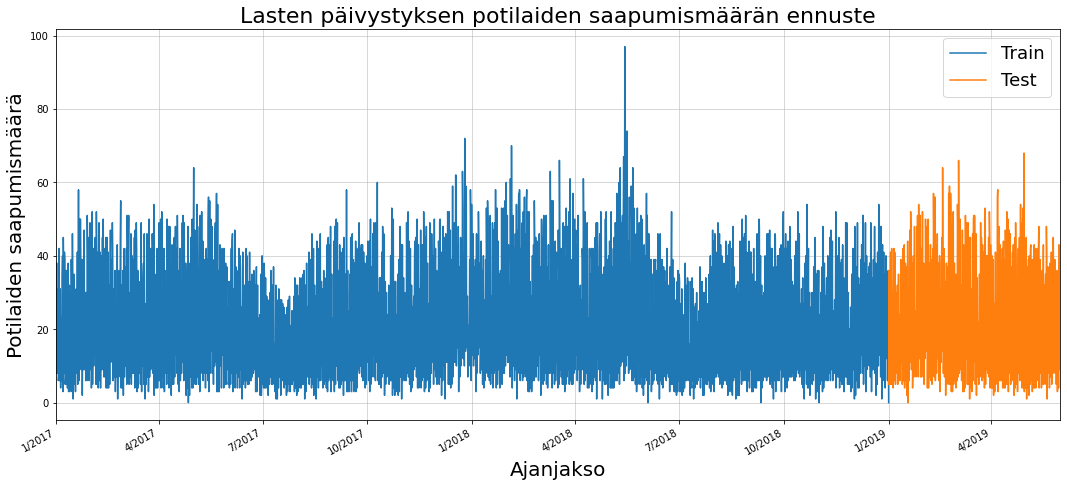

In [11]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df_train_8h.arrivals, ls='-', label='Train')
ax.plot(df_test_8h.arrivals, ls='-', label='Test')
plt.rcParams.update({'font.size': 18})
ax.set_title('Lasten päivystyksen potilaiden saapumismäärän ennuste', fontsize=22)
ax.set_xlabel('Ajanjakso', fontsize=20)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=20)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), 
    pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], 
    ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

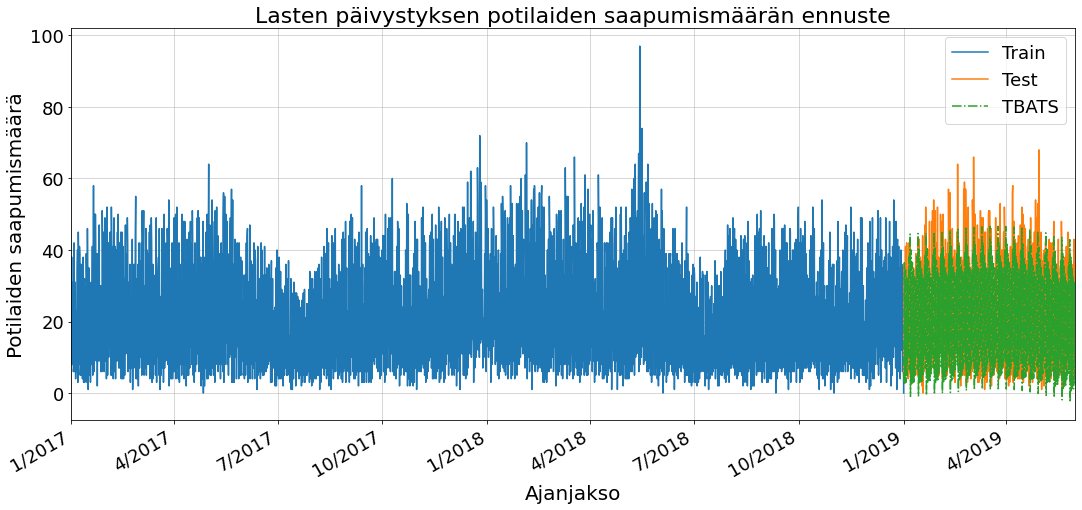

In [12]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df_train_8h.arrivals, ls='-', label='Train')
ax.plot(df_test_8h.arrivals, ls='-', label='Test')
ax.plot(additive.ennuste_TBATS, ls='-.', label='TBATS')
plt.rcParams.update({'font.size': 18})
ax.set_title('Lasten päivystyksen potilaiden saapumismäärän ennuste', fontsize=22)
plt.xlabel('Ajanjakso', fontsize=20)
plt.ylabel('Potilaiden saapumismäärä', fontsize=20)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), 
pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], 
['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

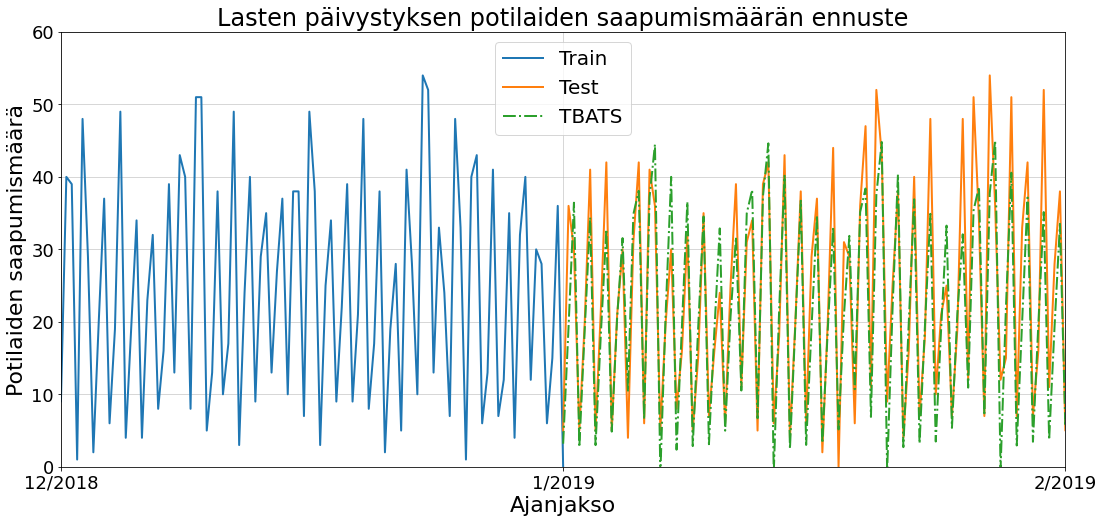

In [13]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df_train_8h.arrivals, ls='-', label='Train', linewidth=2)
ax.plot(df_test_8h.arrivals, ls='-', label='Test', linewidth=2)
ax.plot(additive.ennuste_TBATS, ls='-.', label='TBATS', linewidth=2)
plt.rcParams.update({'font.size': 20})
ax.set_title('Lasten päivystyksen potilaiden saapumismäärän ennuste', fontsize=24)
plt.xlabel('Ajanjakso', fontsize=22)
plt.ylabel('Potilaiden saapumismäärä', fontsize=22)
ax.legend(loc='best')
plt.margins(x=0)
plt.xticks([pd.Timestamp('2018-12-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-01')], ['12/2018', '1/2019', '2/2019'])
plt.grid(linewidth=0.5)
plt.ylim([0, 60])
plt.xlim([pd.Timestamp('2018-12-01'), pd.Timestamp('2019-02-01')])
plt.show()

In [14]:
aika = train_test_8h
span_day = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 8768, 8)]})
timestamp_day = [aika + timedelta(hours=x) for x in range(0, 8760, 8)]
year_test_8h = pd.DataFrame(data={'time':timestamp_day})
year_test_8h['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
year_test_8h['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_8h['timespan']).contains(b) for b in df_test['alkuhetki']]).sum()
year_test_8h['departments'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_8h['timespan']).contains(b) for b in df_test['loppuhetki']]).sum()
year_test_8h['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_8h['timespan']).overlaps(b) for b in df_test['aikaväli']]).sum()
year_test_8h.set_index('time', inplace=True)
year_test_8h.head()

,timespan,arrivals,departments,patient_count
time,,,,
2019-01-01 00:00:00,"[2019-01-01, 2019-01-01 08:00:00)",5,4,5
2019-01-01 08:00:00,"[2019-01-01 08:00:00, 2019-01-01 16:00:00)",36,27,37
2019-01-01 16:00:00,"[2019-01-01 16:00:00, 2019-01-02)",30,39,40
2019-01-02 00:00:00,"[2019-01-02, 2019-01-02 08:00:00)",5,6,6
2019-01-02 08:00:00,"[2019-01-02 08:00:00, 2019-01-02 16:00:00)",20,15,20


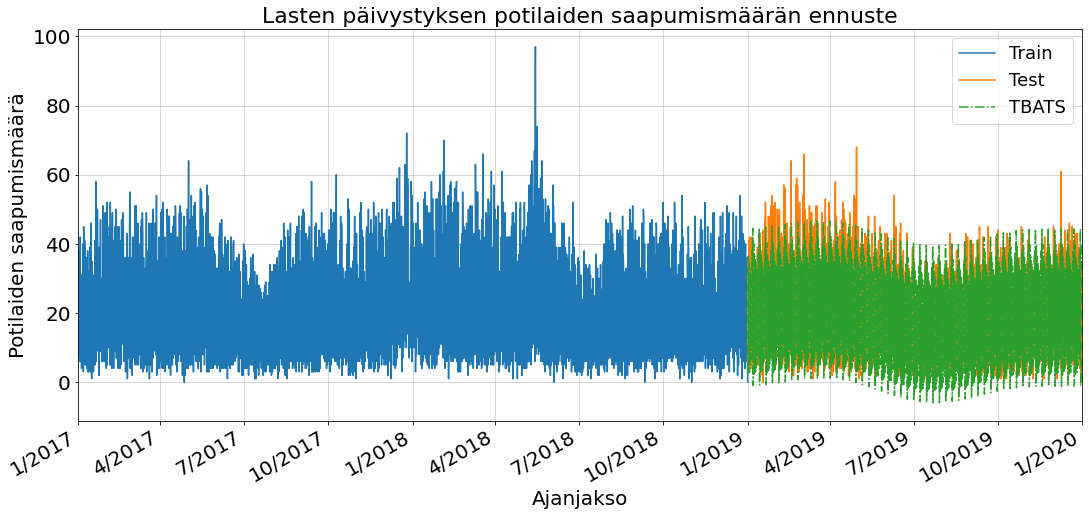

In [15]:
new_index = pd.date_range("2019-01-01", "2019-12-31", freq='8H')
year_pred = pd.DataFrame(np.nan, index=new_index[:-1], columns=df_train_8h.columns)
year_pred.timespan = pd.arrays.IntervalArray.from_arrays(left = new_index[:-1], right = new_index[1:], closed='left')
year_pred['TBATS'] = tbats.forecast(steps=1092)

fig, ax = plt.subplots(figsize=(18, 8))
plt.rcParams.update({'font.size': 18})
ax.plot(df_train_8h.arrivals, ls='-', label='Train')
ax.plot(year_test_8h.arrivals, ls='-', label='Test')
ax.plot(year_pred.TBATS, ls='-.', label='TBATS')
ax.set_title('Lasten päivystyksen potilaiden saapumismäärän ennuste', fontsize=22)
ax.set_xlabel('Ajanjakso', fontsize=20)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=20)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), 
    pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01'), 
    pd.Timestamp('2019-07-01'), pd.Timestamp('2019-10-01'), pd.Timestamp('2019-12-31')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', 
    '7/2018', '10/2018', '1/2019', '4/2019', '7/2019', '10/2019', '1/2020'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

In [16]:
#pickle.dump(tbats, open('tbats_ER_2017-2019-triple_final.pkl', 'wb'))

In [17]:
def sym_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2)) * 100

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean(np.power((y_true - y_pred), 2))

## Tulokset
### Viiden kuukauden ennuste

In [18]:
y_pred = additive.ennuste_TBATS
smape = sym_mean_absolute_percentage_error(df_test_8h.arrivals, y_pred)
mae = mean_absolute_error(df_test_8h.arrivals, y_pred)
mse = mean_squared_error(df_test_8h.arrivals, y_pred)
rmse = np.sqrt(mse)
print('SMAPE TBATS:', smape)
print('MAE TBATS:', mae)
print('MSE TBATS:', mse)
print('RMSE TBATS:', rmse)

SMAPE TBATS: 34.77616414259594
MAE TBATS: 5.197099874016846
MSE TBATS: 50.085694256573845
RMSE TBATS: 7.077124716759896


### 42 päivän ennuste

In [19]:
y_pred = additive.ennuste_TBATS[:126]
smape = sym_mean_absolute_percentage_error(df_test_8h.arrivals[:126], y_pred)
mae = mean_absolute_error(df_test_8h.arrivals[:126], y_pred)
mse = mean_squared_error(df_test_8h.arrivals[:126], y_pred)
rmse = np.sqrt(mse)
print('SMAPE TBATS:', smape)
print('MAE TBATS:', mae)
print('MSE TBATS:', mse)
print('RMSE TBATS:', rmse)

SMAPE TBATS: 35.613126323432105
MAE TBATS: 5.098481851505128
MSE TBATS: 45.424156335489954
RMSE TBATS: 6.739744530432141


### 30 päivän ennuste

In [20]:
y_pred = additive.ennuste_TBATS[:90]
smape = sym_mean_absolute_percentage_error(df_test_8h.arrivals[:90], y_pred)
mae = mean_absolute_error(df_test_8h.arrivals[:90], y_pred)
mse = mean_squared_error(df_test_8h.arrivals[:90], y_pred)
rmse = np.sqrt(mse)
print('SMAPE TBATS:', smape)
print('MAE TBATS:', mae)
print('MSE TBATS:', mse)
print('RMSE TBATS:', rmse)

SMAPE TBATS: 36.7247108170796
MAE TBATS: 5.0806405112380375
MSE TBATS: 44.27532593058344
RMSE TBATS: 6.653970689038497
